In [1]:
#ignoring the warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [26]:
#importing the necessary packages
import numpy as np
import cv2
import os
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#setting arguments 
args = {"dataset": "./dataset",
        "model": "corona.model"
       }

In [3]:
"""initializing the initial learning rate, epochs to train
   and batch size"""
learningRate = 1e-3
epochs = 61
batchSize = 8

In [4]:
"""listing out the images in the dataset folder, then initializing
   the list of data (images) and class images"""
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

#looping over the images paths
for imagePath in imagePaths:
    
    #extracting the class label from image paths
    label = imagePath.split(os.path.sep)[-2]

    """loading the images, changing color channels and resizing it to be a fixed
       224x224 pixels"""
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    #updating the data and labels lists
    data.append(image)
    labels.append(label)

"""converting the data and labels to NumPy arrays and scaling the pixel
   intensities to the range [0, 255]"""
data = np.array(data) / 255.0
labels = np.array(labels)

In [5]:
#using one-hot encoding on labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

"""splitting the data into training and testing using 80% of
   the data for training and 20% for testing"""
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, 
                                                  random_state=42)

#initializing the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [6]:
#loading the VGG16 network, ensuring the head FC layer sets are left
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

"""constructing the main model that will be placed on top of the
   the base model"""
mainModel = baseModel.output
mainModel = AveragePooling2D(pool_size=(4, 4))(mainModel)
mainModel = Flatten(name="flatten")(mainModel)
mainModel = Dense(64, activation="relu")(mainModel)
mainModel = Dropout(0.5)(mainModel)
mainModel = Dense(2, activation="softmax")(mainModel)

#lace the head FC model on top of the base model (actual model)
model = Model(inputs=baseModel.input, outputs=mainModel)

"""looping over all layers in the base model and freeze them so they will 
   not be updated during the first training process"""
for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
#compiling up the model
optimizer = Adam(lr=learningRate, decay=learningRate / epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#training the head of the network
networkHead = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=batchSize),
    steps_per_epoch=len(trainX) // batchSize,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batchSize,
    epochs=epochs)

Epoch 1/61
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 11s 1s/step - loss: 0.7579 - acc: 0.4773 - val_loss: 0.6252 - val_acc: 0.5652
Epoch 2/61
11/11 [==============================] - 13s 1s/step - loss: 0.6596 - acc: 0.6250 - val_loss: 0.5809 - val_acc: 0.7826
Epoch 3/61
11/11 [==============================] - 14s 1s/step - loss: 0.6198 - acc: 0.6818 - val_loss: 0.5513 - val_acc: 0.7826
Epoch 4/61
11/11 [==============================] - 14s 1s/step - loss: 0.5679 - acc: 0.7500 - val_loss: 0.5211 - val_acc: 0.7826
Epoch 5/61
11/11 [==============================] - 14s 1s/step - loss: 0.5355 - acc: 0.7727 - val_loss: 0.4935 - val_acc: 0.8261
Epoch 6/61
11/11 [==============================] - 14s 1s/step - loss: 0.4718 - acc: 0.8636 - val_loss: 0.4719 - val_acc: 0.8696
Epoch 7/61
11/11 [==============================] - 14s 1s/step - loss: 0.4235 - acc: 0.8864 - val_loss: 0.4512 - val_acc: 0.7

Epoch 61/61
11/11 [==============================] - 15s 1s/step - loss: 0.0959 - acc: 0.9659 - val_loss: 0.1501 - val_acc: 0.9565


In [8]:
#making predictions on the testing data
predIndexs = model.predict(testX, batch_size=batchSize)

"""for each image in the testing data we need to find the index of the
   label with corresponding largest predicted probability"""
predIndexs = np.argmax(predIndexs, axis=1)

#printing classification report
print(classification_report(testY.argmax(axis=1), predIndexs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.92      0.96        13
      normal       0.91      1.00      0.95        10

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



In [9]:
#computing the confusion matrix and use it to derive the raw accuracy
cm = confusion_matrix(testY.argmax(axis=1), predIndexs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total

# printing confusion matrix, accuracy
print(cm)
print("acc: {:.4f}".format(acc))

[[12  1]
 [ 0 10]]
acc: 0.9565


In [11]:
#saving the model
model.save(args["model"])

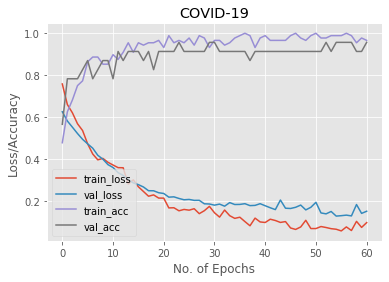

In [10]:
#plotting the training loss and accuracy
numberEpochs = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberEpochs), networkHead.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberEpochs), networkHead.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberEpochs), networkHead.history["acc"], label="train_acc")
plt.plot(np.arange(0, numberEpochs), networkHead.history["val_acc"], label="val_acc")
plt.title("COVID-19")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [12]:
#testing out the model
import tensorflow as tf

#loading the model
model = tf.keras.models.load_model("/home/apoorvsrivastava/detect-corona/corona.model")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
#picking up test image-Normal
testImage = cv2.imread("/home/apoorvsrivastava/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0013-0001.jpeg")

In [22]:
#picking up test image-Corona

testImage = cv2.imread("/home/apoorvsrivastava/Downloads/covid-chestxray-dataset-master/images/23E99E2E-447C-46E5-8EB2-D35D12473C39.png")

In [23]:
#preprocessing the test image
image = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = image.astype("float") / 255.0

In [24]:
#reshaping the numpy array according to image size
image = np.array(image).reshape(1,224,224,3)

#doing prediction on test image
pred = model.predict(image)
pred = pred.argmax(axis=1)[0]

In [25]:
#putting text on image and showing output image
imageText = "Corona Negative" if pred == 1 else "Corona Positive"
color = (0, 255, 0) if pred == 1 else (0, 0, 255)

testImage = cv2.resize(testImage, (424, 424))
cv2.putText(testImage, imageText, (3, 20), cv2.FONT_ITALIC, 0.5,color, 2)
cv2.imshow("Results", testImage)
cv2.waitKey(0)
cv2.destroyAllWindows()